# Changes from v3: 
#####  1. Applied label smoothing for both fake and real images on discriminator training. Label smoothing value is selected uniform randomly between 0.1 - 0.2. 

In [1]:
import os

DATA_DIR = 'DIR'
print(os.listdir(DATA_DIR))

['images']


In [2]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import numpy as np

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

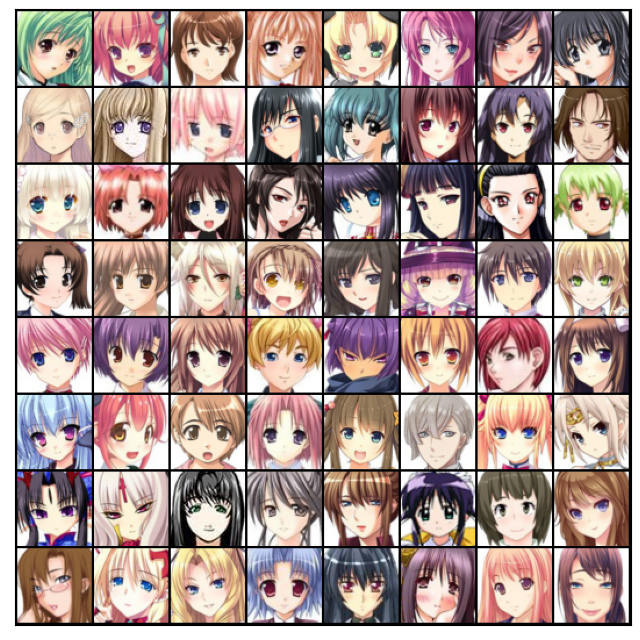

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


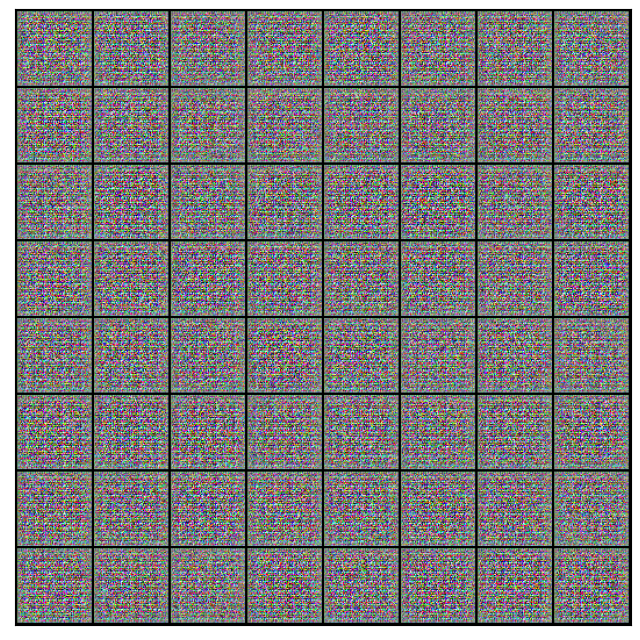

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
import random

def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    # Applying label smoothing by reducing the real labels slighly less from 1. 
    real_targets = torch.ones(real_images.size(0), 1, device=device) - random.uniform(0.1, 0.2)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
     # Applying label smoothing by increasing the fake labels slighly more from 0. 
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device) + random.uniform(0.1, 0.2)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights only if loss is greater than threshold
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score


In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


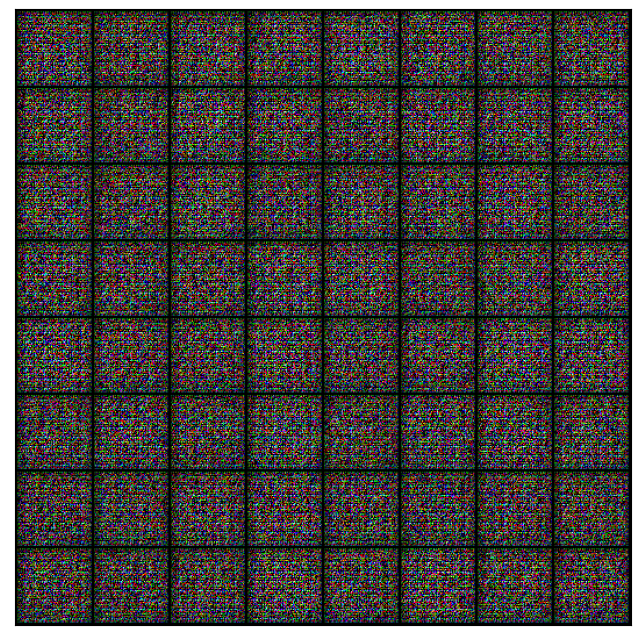

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [27]:
def fit(epochs, lr, start_idx=1, losses_g=[], losses_d=[], real_scores=[], fake_scores=[]):
    torch.cuda.empty_cache()
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        
        batch_losses_d, batch_losses_g, batch_real_scores, batch_fake_scores= [], [], [], []        
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
           
            # Train generator
            loss_g = train_generator(opt_g)
       
            batch_losses_g.append(loss_g)
            batch_losses_d.append(loss_d)
            batch_real_scores.append(real_score)
            batch_fake_scores.append(fake_score)
        

        # Record losses & scores
        losses_g.extend(batch_losses_g)
        losses_d.extend(batch_losses_d)
        
        real_scores.extend(batch_real_scores)
        fake_scores.extend(batch_fake_scores)

        
        # Calculate epoch scores
        epoch_loss_g = np.mean(losses_g[-len(batch_losses_g):])
        epoch_loss_d = np.mean(losses_d[-len(batch_losses_d):])

        
        epoch_real_score = np.mean(real_scores[-len(batch_real_scores):])
        epoch_fake_score = np.mean(fake_scores[-len(batch_fake_scores):])

        
        # Log losses & scores (last batch)
        print(f"Epoch [{ epoch+1}/{epochs}]")
        print(f'Loss_D: {epoch_loss_d:.3f}, Loss_G: {epoch_loss_g:.3f}')
        print(f'Real_Score: {real_score:.3f}, Fake_Score: {fake_score:.3f}') 
        # Save generated images
        if (epoch+start_idx) % 10 == 0:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002
epochs = 100

In [29]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/100]
Loss_D: 1.149, Loss_G: 2.732
Real_Score: 0.682, Fake_Score: 0.167


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/100]
Loss_D: 1.113, Loss_G: 2.456
Real_Score: 0.611, Fake_Score: 0.167


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/100]
Loss_D: 1.060, Loss_G: 2.481
Real_Score: 0.803, Fake_Score: 0.393


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/100]
Loss_D: 1.024, Loss_G: 2.503
Real_Score: 0.888, Fake_Score: 0.501


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/100]
Loss_D: 1.009, Loss_G: 2.492
Real_Score: 0.767, Fake_Score: 0.288


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/100]
Loss_D: 1.023, Loss_G: 2.330
Real_Score: 0.820, Fake_Score: 0.417


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/100]
Loss_D: 1.036, Loss_G: 2.237
Real_Score: 0.695, Fake_Score: 0.256


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/100]
Loss_D: 1.022, Loss_G: 2.155
Real_Score: 0.834, Fake_Score: 0.351


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/100]
Loss_D: 1.027, Loss_G: 2.047
Real_Score: 0.755, Fake_Score: 0.284


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/100]
Loss_D: 1.016, Loss_G: 1.993
Real_Score: 0.815, Fake_Score: 0.374
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/100]
Loss_D: 1.023, Loss_G: 1.924
Real_Score: 0.898, Fake_Score: 0.473


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/100]
Loss_D: 1.002, Loss_G: 1.861
Real_Score: 0.860, Fake_Score: 0.344


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/100]
Loss_D: 1.013, Loss_G: 1.869
Real_Score: 0.617, Fake_Score: 0.135


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/100]
Loss_D: 0.994, Loss_G: 1.877
Real_Score: 0.826, Fake_Score: 0.279


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/100]
Loss_D: 1.001, Loss_G: 1.830
Real_Score: 0.804, Fake_Score: 0.227


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/100]
Loss_D: 0.986, Loss_G: 1.845
Real_Score: 0.761, Fake_Score: 0.186


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/100]
Loss_D: 0.977, Loss_G: 1.844
Real_Score: 0.392, Fake_Score: 0.056


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/100]
Loss_D: 0.983, Loss_G: 1.858
Real_Score: 0.786, Fake_Score: 0.286


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/100]
Loss_D: 1.009, Loss_G: 1.839
Real_Score: 0.806, Fake_Score: 0.333


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/100]
Loss_D: 0.969, Loss_G: 1.800
Real_Score: 0.712, Fake_Score: 0.142
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/100]
Loss_D: 0.975, Loss_G: 1.836
Real_Score: 0.855, Fake_Score: 0.259


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/100]
Loss_D: 0.953, Loss_G: 1.829
Real_Score: 0.541, Fake_Score: 0.084


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/100]
Loss_D: 0.962, Loss_G: 1.821
Real_Score: 0.787, Fake_Score: 0.245


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/100]
Loss_D: 0.980, Loss_G: 1.809
Real_Score: 0.692, Fake_Score: 0.110


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/100]
Loss_D: 0.937, Loss_G: 1.831
Real_Score: 0.939, Fake_Score: 0.437


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/100]
Loss_D: 1.025, Loss_G: 1.753
Real_Score: 0.767, Fake_Score: 0.186


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/100]
Loss_D: 0.942, Loss_G: 1.793
Real_Score: 0.687, Fake_Score: 0.126


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/100]
Loss_D: 0.958, Loss_G: 1.827
Real_Score: 0.744, Fake_Score: 0.163


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/100]
Loss_D: 0.929, Loss_G: 1.839
Real_Score: 0.825, Fake_Score: 0.237


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/100]
Loss_D: 0.937, Loss_G: 1.840
Real_Score: 0.903, Fake_Score: 0.331
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/100]
Loss_D: 0.960, Loss_G: 1.813
Real_Score: 0.790, Fake_Score: 0.177


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/100]
Loss_D: 0.930, Loss_G: 1.851
Real_Score: 0.803, Fake_Score: 0.199


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/100]
Loss_D: 0.928, Loss_G: 1.858
Real_Score: 0.868, Fake_Score: 0.319


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/100]
Loss_D: 1.005, Loss_G: 1.742
Real_Score: 0.727, Fake_Score: 0.124


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/100]
Loss_D: 0.966, Loss_G: 1.795
Real_Score: 0.834, Fake_Score: 0.229


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/100]
Loss_D: 0.918, Loss_G: 1.847
Real_Score: 0.929, Fake_Score: 0.339


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/100]
Loss_D: 0.917, Loss_G: 1.871
Real_Score: 0.813, Fake_Score: 0.209


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/100]
Loss_D: 0.969, Loss_G: 1.798
Real_Score: 0.891, Fake_Score: 0.276


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/100]
Loss_D: 0.916, Loss_G: 1.864
Real_Score: 0.719, Fake_Score: 0.135


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/100]
Loss_D: 0.919, Loss_G: 1.866
Real_Score: 0.809, Fake_Score: 0.180
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/100]
Loss_D: 1.060, Loss_G: 1.703
Real_Score: 0.806, Fake_Score: 0.155


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/100]
Loss_D: 0.907, Loss_G: 1.833
Real_Score: 0.789, Fake_Score: 0.130


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/100]
Loss_D: 0.907, Loss_G: 1.855
Real_Score: 0.721, Fake_Score: 0.114


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/100]
Loss_D: 0.948, Loss_G: 1.822
Real_Score: 0.912, Fake_Score: 0.250


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/100]
Loss_D: 0.906, Loss_G: 1.867
Real_Score: 0.665, Fake_Score: 0.081


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/100]
Loss_D: 0.974, Loss_G: 1.823
Real_Score: 0.540, Fake_Score: 0.100


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/100]
Loss_D: 0.912, Loss_G: 1.814
Real_Score: 0.740, Fake_Score: 0.137


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/100]
Loss_D: 0.901, Loss_G: 1.864
Real_Score: 0.796, Fake_Score: 0.137


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/100]
Loss_D: 0.914, Loss_G: 1.878
Real_Score: 0.860, Fake_Score: 0.219


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/100]
Loss_D: 0.907, Loss_G: 1.893
Real_Score: 0.932, Fake_Score: 0.469
Saving generated-images-0050.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [51/100]
Loss_D: 1.058, Loss_G: 1.639
Real_Score: 0.844, Fake_Score: 0.209


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [52/100]
Loss_D: 0.897, Loss_G: 1.849
Real_Score: 0.810, Fake_Score: 0.141


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [53/100]
Loss_D: 0.904, Loss_G: 1.858
Real_Score: 0.914, Fake_Score: 0.296


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [54/100]
Loss_D: 0.906, Loss_G: 1.874
Real_Score: 0.916, Fake_Score: 0.359


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [55/100]
Loss_D: 0.967, Loss_G: 1.811
Real_Score: 0.829, Fake_Score: 0.159


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [56/100]
Loss_D: 0.903, Loss_G: 1.872
Real_Score: 0.866, Fake_Score: 0.309


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [57/100]
Loss_D: 0.897, Loss_G: 1.873
Real_Score: 0.775, Fake_Score: 0.143


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [58/100]
Loss_D: 0.897, Loss_G: 1.889
Real_Score: 0.867, Fake_Score: 0.208


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [59/100]
Loss_D: 0.970, Loss_G: 1.820
Real_Score: 0.739, Fake_Score: 0.202


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [60/100]
Loss_D: 0.898, Loss_G: 1.843
Real_Score: 0.743, Fake_Score: 0.116
Saving generated-images-0060.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [61/100]
Loss_D: 0.898, Loss_G: 1.874
Real_Score: 0.824, Fake_Score: 0.148


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [62/100]
Loss_D: 0.896, Loss_G: 1.883
Real_Score: 0.819, Fake_Score: 0.158


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [63/100]
Loss_D: 0.901, Loss_G: 1.876
Real_Score: 0.703, Fake_Score: 0.098


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [64/100]
Loss_D: 0.900, Loss_G: 1.897
Real_Score: 0.849, Fake_Score: 0.213


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [65/100]
Loss_D: 0.934, Loss_G: 1.865
Real_Score: 0.800, Fake_Score: 0.216


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [66/100]
Loss_D: 0.891, Loss_G: 1.876
Real_Score: 0.827, Fake_Score: 0.188


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [67/100]
Loss_D: 0.891, Loss_G: 1.897
Real_Score: 0.868, Fake_Score: 0.265


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [68/100]
Loss_D: 0.893, Loss_G: 1.909
Real_Score: 0.802, Fake_Score: 0.148


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [69/100]
Loss_D: 0.902, Loss_G: 1.880
Real_Score: 0.788, Fake_Score: 0.165


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [70/100]
Loss_D: 0.895, Loss_G: 1.896
Real_Score: 0.804, Fake_Score: 0.146
Saving generated-images-0070.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [71/100]
Loss_D: 0.899, Loss_G: 1.881
Real_Score: 0.879, Fake_Score: 0.272


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [72/100]
Loss_D: 0.890, Loss_G: 1.906
Real_Score: 0.876, Fake_Score: 0.232


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [73/100]
Loss_D: 1.137, Loss_G: 1.628
Real_Score: 0.843, Fake_Score: 0.335


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [74/100]
Loss_D: 0.897, Loss_G: 1.789
Real_Score: 0.798, Fake_Score: 0.125


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [75/100]
Loss_D: 0.888, Loss_G: 1.859
Real_Score: 0.804, Fake_Score: 0.192


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [76/100]
Loss_D: 0.888, Loss_G: 1.896
Real_Score: 0.787, Fake_Score: 0.096


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [77/100]
Loss_D: 0.892, Loss_G: 1.888
Real_Score: 0.836, Fake_Score: 0.166


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [78/100]
Loss_D: 0.891, Loss_G: 1.898
Real_Score: 0.825, Fake_Score: 0.148


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [79/100]
Loss_D: 0.893, Loss_G: 1.891
Real_Score: 0.819, Fake_Score: 0.147


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [80/100]
Loss_D: 0.893, Loss_G: 1.901
Real_Score: 0.680, Fake_Score: 0.102
Saving generated-images-0080.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [81/100]
Loss_D: 1.003, Loss_G: 1.725
Real_Score: 0.864, Fake_Score: 0.269


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [82/100]
Loss_D: 0.886, Loss_G: 1.866
Real_Score: 0.880, Fake_Score: 0.262


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [83/100]
Loss_D: 0.891, Loss_G: 1.868
Real_Score: 0.849, Fake_Score: 0.215


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [84/100]
Loss_D: 0.944, Loss_G: 1.902
Real_Score: 0.731, Fake_Score: 0.628


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [85/100]
Loss_D: 1.094, Loss_G: 1.448
Real_Score: 0.778, Fake_Score: 0.161


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [86/100]
Loss_D: 0.884, Loss_G: 1.849
Real_Score: 0.832, Fake_Score: 0.210


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [87/100]
Loss_D: 0.890, Loss_G: 1.874
Real_Score: 0.812, Fake_Score: 0.157


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [88/100]
Loss_D: 0.918, Loss_G: 1.865
Real_Score: 0.757, Fake_Score: 0.138


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [89/100]
Loss_D: 0.887, Loss_G: 1.863
Real_Score: 0.816, Fake_Score: 0.161


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [90/100]
Loss_D: 0.883, Loss_G: 1.884
Real_Score: 0.807, Fake_Score: 0.190
Saving generated-images-0090.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [91/100]
Loss_D: 0.889, Loss_G: 1.897
Real_Score: 0.864, Fake_Score: 0.206


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [92/100]
Loss_D: 0.885, Loss_G: 1.904
Real_Score: 0.861, Fake_Score: 0.164


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [93/100]
Loss_D: 0.975, Loss_G: 1.797
Real_Score: 0.821, Fake_Score: 0.180


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [94/100]
Loss_D: 0.887, Loss_G: 1.844
Real_Score: 0.861, Fake_Score: 0.195


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [95/100]
Loss_D: 0.879, Loss_G: 1.876
Real_Score: 0.760, Fake_Score: 0.095


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [96/100]
Loss_D: 0.889, Loss_G: 1.891
Real_Score: 0.886, Fake_Score: 0.198


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [97/100]
Loss_D: 0.897, Loss_G: 1.883
Real_Score: 0.926, Fake_Score: 0.286


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [98/100]
Loss_D: 0.882, Loss_G: 1.902
Real_Score: 0.894, Fake_Score: 0.237


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [99/100]
Loss_D: 0.888, Loss_G: 1.886
Real_Score: 0.741, Fake_Score: 0.131


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [100/100]
Loss_D: 0.887, Loss_G: 1.902
Real_Score: 0.773, Fake_Score: 0.131
Saving generated-images-0100.png


In [30]:
losses_g, losses_d, real_scores, fake_scores = history

In [31]:
import pandas as pd

def plot_results(dist1, dist2, title, window_size1=len(train_dl), window_size2=len(train_dl)):
    x1 = np.arange(0, len(dist1), 1)
    x2 = np.arange(0, len(dist2), 1)
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Calculate the rolling means for each distribution
    rolling_mean1 = pd.Series(dist1).rolling(window=window_size1).mean()
    rolling_mean2 = pd.Series(dist2).rolling(window=window_size2).mean()
    
    # Plot the distributions with shading between rolling means
    ax.fill_between(x1, dist1, rolling_mean1, alpha=0.3, label='Real', color='blue')
    ax.fill_between(x2, dist2, rolling_mean2, alpha=0.3, label='Fake', color='orange')

    # Plot the rolling means as lines
    ax.plot(x1, rolling_mean1, label='Moving Mean Real', color='blue')
    ax.plot(x2, rolling_mean2, label='Moving Mean Fake', color='orange')

    # Customize the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.legend()

    # Show the plot
    plt.show()    

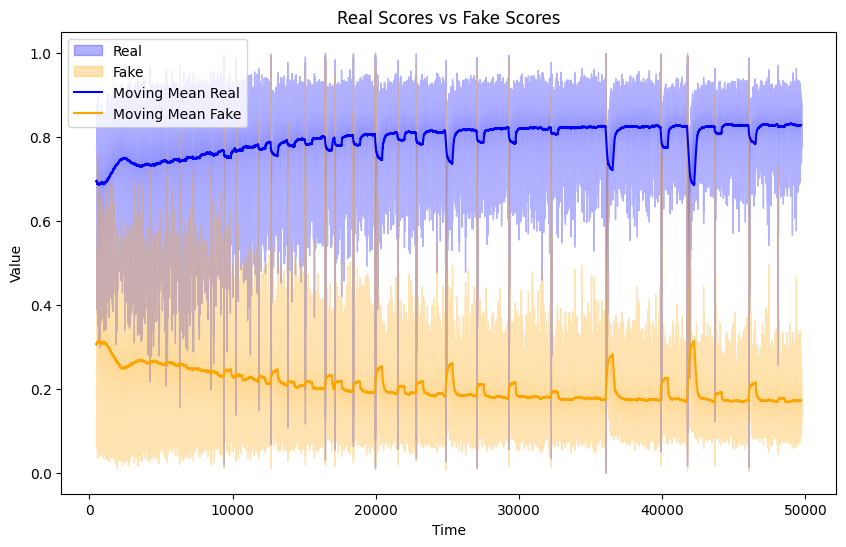

In [32]:
plot_results(real_scores, fake_scores, 'Real Scores vs Fake Scores')

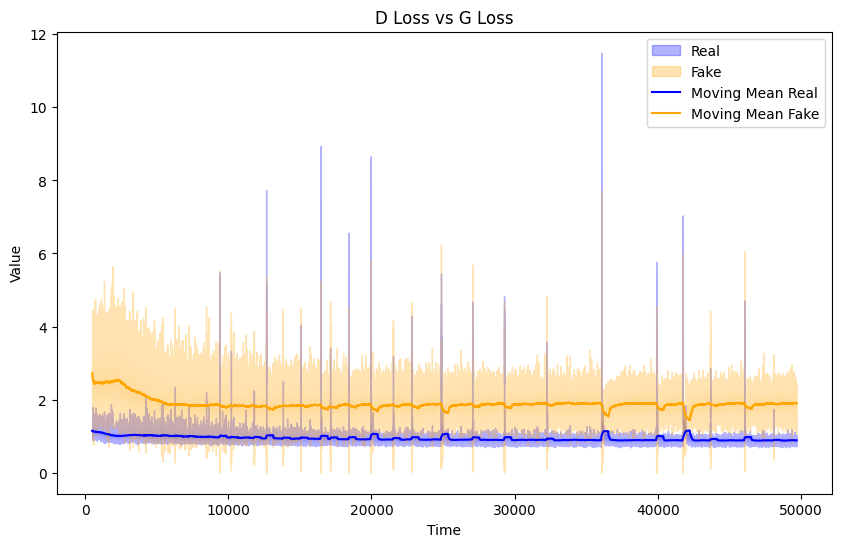

In [33]:
plot_results(losses_d, losses_g, 'D Loss vs G Loss')

In [34]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Gv4.pth')
torch.save(discriminator.state_dict(), 'Dv4.pth')

In [35]:
import cv2
import os

vid_fname = 'gans_training_v4.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [36]:
from IPython.display import Image

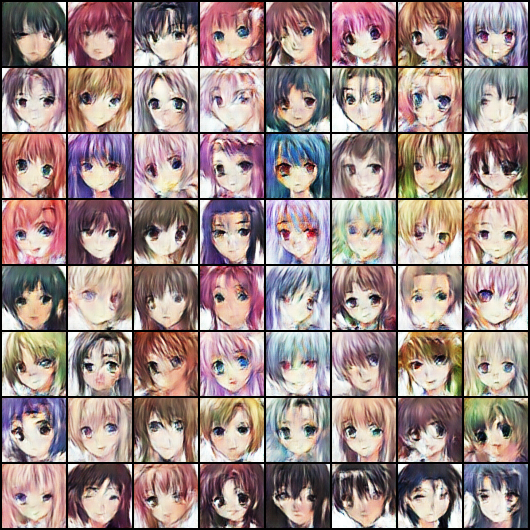

In [37]:
Image('./generated/generated-images-0010.png')

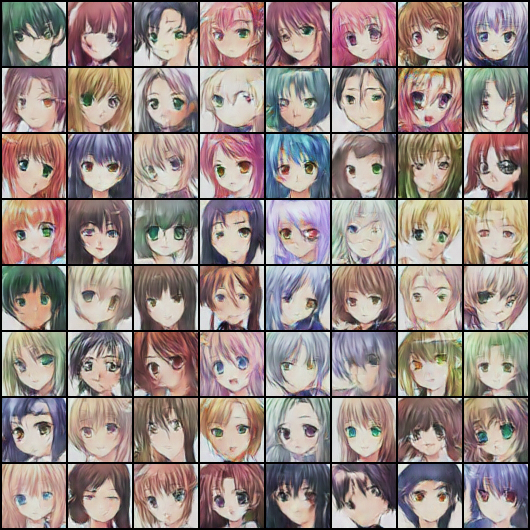

In [38]:
Image('./generated/generated-images-0020.png')

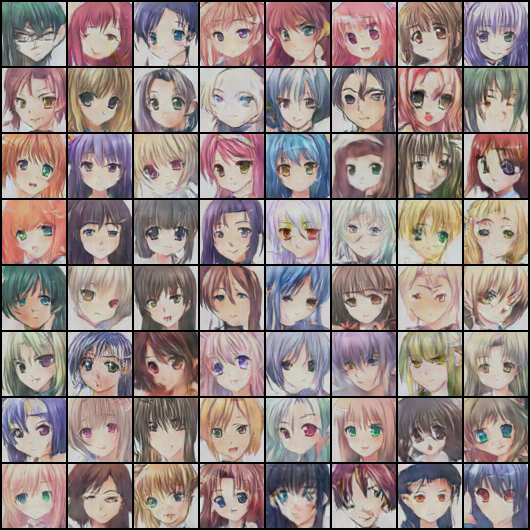

In [39]:
Image('./generated/generated-images-0050.png')

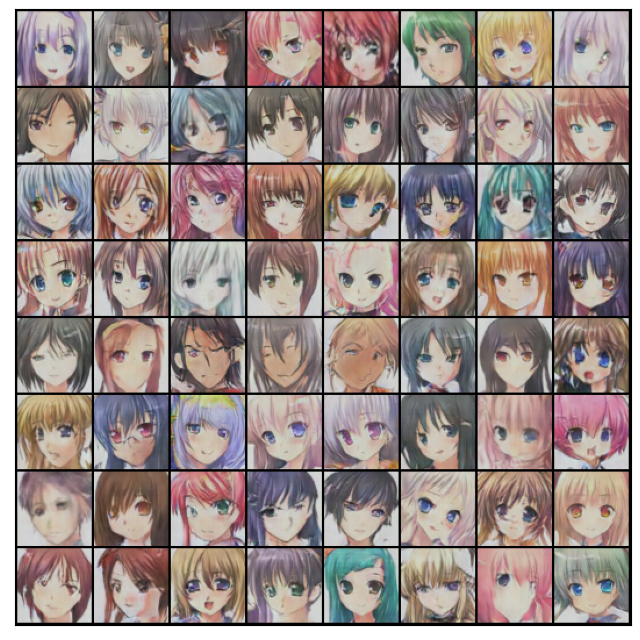

In [40]:
new_latent = torch.randn(64, latent_size, 1, 1, device=device)

fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

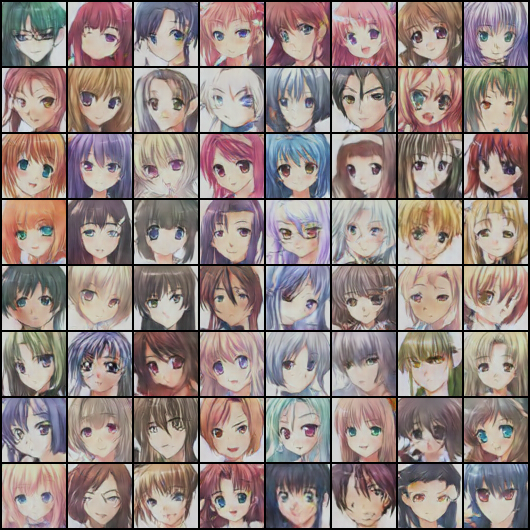

In [41]:
Image('./generated/generated-images-0100.png')

tensor([[0.0715]], device='cuda:0', grad_fn=<SigmoidBackward0>)


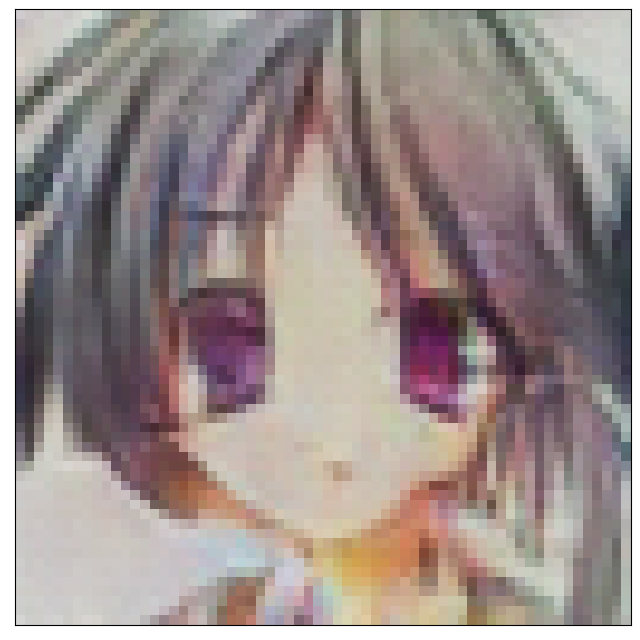

In [42]:
new_latent = torch.randn(1, latent_size, 1, 1, device=device)
fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
print(discriminator(generator(new_latent)))